<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales </p>
<p style="margin: 0; text-align:right;">MU Ingeniería Computacional y Matemática / Área de Inteligencia Artificial</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Laura Rivera Sanchez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>



# Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales 

Falta resumen

In [3]:
#librerias necesarias:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import random
import skimage

In [4]:
#En caso de utilizar google colab:
#from google.colab import drive
#drive.mount('/content/gdrive')

# Lectura y análisis de los conjuntos de datos






## Base de datos 2d FootWear con información de marca

Base de datos extraída de: https://iastate.figshare.com/articles/figure/2D_Footwear_outsole_impressions/11624073/1

https://www.sciencedirect.com/science/article/pii/S2352340920304029?via%3Dihub

In [ ]:
with ZipFile('data/2dFootwear/Part1.zip', 'r') as zipObj:
  zipObj.extractall('images')

with ZipFile('data/2dFootwear/Part2.zip', 'r') as zipObj:
  zipObj.extractall('images')



In [ ]:
with ZipFile('data/2dFootwear/Part3.zip', 'r') as zipObj:
  zipObj.extractall('images')

with ZipFile('data/2dFootwear/Part4.zip', 'r') as zipObj:
  zipObj.extractall('images')

with ZipFile('data/2dFootwear/Part5.zip', 'r') as zipObj:
  zipObj.extractall('images')

### Análisis de los datos 2d Footwear
(Explicar)

In [5]:
df = pd.read_csv('data/2dFootwear/Data-information.csv', delimiter=';')
df['Brand'] = df['Brand'].str.strip() #eliminar espacios en blanco

X_files = df['ID'].values.tolist()
brands = df['Brand'].values.tolist()

values_brand, counts_brand = np.unique(brands, return_counts=True)
print('Tag example:',X_files[0]) #nomenclatura 
print('Nº lines:',len(X_files)) #lineas en el csv
individuals, count_ind = np.unique(df['ID'].str[:3], return_counts=True)
print('Nº different people:',len(individuals)) #diferentes individuos de la muestra
num_classes = len(values_brand) #se guarda porque será necesario para crear el modelo
print('Nº of different brands: %d' %num_classes) #marcas diferentes
print(values_brand) #Listado de marcas únicas



Tag example: 001_01
Nº lines: 150
Nº different people: 28
Nº of different brands: 60
['Adidas' 'Airspeed' 'Airwalk' 'Aldo' 'American Eagle' 'Arizona' 'Asics'
 'BAGO' 'BASS' 'Birkenstock' 'Brooks' 'CalvinKlain' 'Champion' 'Clarks'
 'Columbus' 'Converse' 'Cooeli' 'Court classic' 'Dansko' 'Deer Stags'
 'Dockers' 'Ecco' 'Elcanto' 'Fadedglory' 'Feiyue' 'Fila' 'G.H.Bass&Co'
 'Guho' 'HeyBear' 'K-swiss' 'Keen' 'Landya' 'Namuhana' 'Newbalance' 'Nike'
 'Ninewest' 'None' 'OP' 'Ofem' 'Prospecs' 'Puma' 'Robin' 'Saucony'
 'Shoedy' 'Shoopen' 'Simply vera' 'Skechers' 'Soma' 'Sonoma' 'Sorel'
 'Sperry' 'Stone' 'Sugar' 'T2R' 'Teva' 'Truesoft' 'Under Amour' 'Vans'
 'Vibram' 'Yonex']


A continuación, el histograma con el número de muestras según género, en este caso hay 70 muestras de mujeres y 80 de hombres.

(array([71.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 79.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

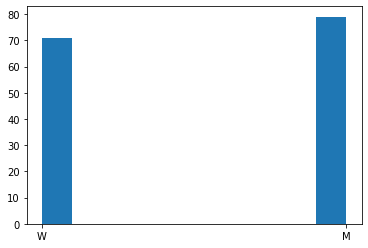

In [6]:
plt.hist(df['Gender'])

Por último, se muestran las cinco marcas que más aparecen en el conjunto de datos. \
Además se seleccionan esas marcas que aparecen minimo 2 veces en la muestra, para crear un subconjunto de datos que elimine las marcas con una única muestra y comprobar en los siguientes casos si influye en el resultado.


Brands with more than 1 register: 7
Brands with only 1 register: 52


<AxesSubplot: xlabel='x'>

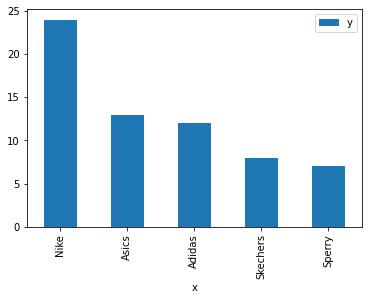

In [7]:

minSamples = 5 #Número mínimo de muestras por marca.

dfbrand = pd.DataFrame({'x':values_brand, 'y':counts_brand}) 
dfbrand = dfbrand.sort_values('y', ascending = False) #ordenar descendientemente

#Eliminar los que tengan "None" como marca:
dfbrand=dfbrand[dfbrand['x']!="None"]
#eliminar los que tengan menos de X muestras:
dfbrandone=dfbrand[dfbrand['y']<minSamples]
dfbrand=dfbrand[dfbrand['y']>=minSamples]
num_classes=len(dfbrand)
print('Brands with more than 1 register: %d' %num_classes) 
print('Brands with only 1 register: %d' %len(dfbrandone)) 
dfbrand = dfbrand.head(5) # mostrar las 5 marcas que más aparecen en el conjunto de datos
dfbrand.plot('x', 'y', kind='bar') #mostrar gráfica



In [8]:



def get_images_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im2=im.resize((400,912))
    im3 = im2.crop((40,40,320,872)) #Quitar marco medidor
    im3.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result

def get_images(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []
  for f in dir_list:  
    result.append(f)


  print('Nº files:',len(result))
  return result

In [9]:
# Get the list of all files in /images and convert to jpeg
#shoeFiles = get_images_to_jpeg("images") #la primera vez para convertir las imágenes
shoeFiles = get_images("images")

Nº files: 1500


## Base de datos Datos FD-300


In [ ]:
#Extracción de los ficheros del zip
with ZipFile('data/FID300/images.zip', 'r') as zipObj:
  zipObj.extractall('fid300')

In [ ]:
#Lectura de la tabla de resultados
df_fid300 = pd.read_csv('data/FID300/label_table.csv', delimiter=',')

En este caso, las imágenes estan divididas en 3 carpetas:

*   *tracks_original*: Conteine las 300 imágenes originales extraidas de la escena del crimen, incluyendo la plantilla de medición.
*   *tracks_cropped*: Contiene las imágenes originales pero ya recortadas.
*  *references*: Contiene las 1175 imágenes de las huellas de referencia, obtenidas de diferentes calzados.

Para el proyecto se decide utilizar las dos últimas categorias, guardandolas en 2 datasets diferenciados: *fid300ref* y *fid300crop*.


**Análisis de los datos FD-300**



In [ ]:
fid300ref = get_images("fid300/references")
fid300crop = get_images("fid300/tracks_cropped")

print(len(df_fid300)) #lineas en el csv
print(fid300ref[0])

In [ ]:

X_files = df_fid300['X'].values.tolist()
y = df_fid300['y'].values.tolist()

values_y, counts_y = np.unique(y, return_counts=True)

print('Nº of references: %d' %len(values_y))

dfref = pd.DataFrame({'x':values_y, 'y':counts_y}) 
dfref = dfref.sort_values('y', ascending = False) 
dfref.head(10) # coger los 5 primeros



### Visualización de imágenes

Se ha creado la función *plot_image* que permite la visualización de las imágenes de cualquiera de las dos bases de datos.

Parámetros:\
*imgPath*: carpeta donde estan las imágenes \
*fileNames*: array con los nombres de los ficheros a mostrar


In [36]:

import skimage
def plot_image(imgPath, fileNames):
  for i in range(len(fileNames)):
    filename = fileNames[i]
    img = skimage.io.imread(imgPath+filename)
   
    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)
  print(fileNames)
  plt.show()

def plot_image2(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)

    plt.show()
def plot_image_grey(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img, cmap='gray')

    plt.show()

A continuación, se muestra una imagen aleatória de cada uno de los 3 datasets del proyecto:

In [ ]:
plot_image("images/",random.choices(shoeFiles,k=1))

In [ ]:

plot_image("fid300/references/",random.choices(fid300ref,k=1))
plot_image("fid300/tracks_cropped/",random.choices(fid300crop,k=1))


## División de los datos

Para la división de los datos se ha utilizado la funcióon train_test_split dos veces, primero para dividir entre el 80% de train y el 20% de test y después para extraer el equivalente al 10% para la validación. 

De esta manera se dispone de 70% train, 20% test y 10% validación.


Antes de dividir los datos de la base de datos 2d Footwear, se ha formateado la tabla ya que actualmente solo muestra la información de marca según el calzado del usuario, pero no contiene el nombre de la imagen, se ha creado la siguiente función para que el conjunto de datos contenga dos columnas (X:fichero, y:marca)

In [10]:
def filesWithBrand(shoeFiles):
  files = []
  brands = []
  for image in shoeFiles:
    files.append(image) #filename
    person = df[df['ID'].str[:6]==image[:6]]  #persona+contador de calzado
    brands.append(person['Brand'].iloc[0])

  return pd.DataFrame({'X':files, 'y':brands}) 


df_shoe_brand = filesWithBrand(shoeFiles)
#eliminar aquellas marcas que no aparecen mínimo en "minSample" muestras 
df_shoe_brand=df_shoe_brand[~df_shoe_brand['y'].isin(dfbrandone['x'].to_numpy())]
df_shoe_brand=df_shoe_brand[df_shoe_brand['y']!="None"]
df_shoe_brand['factor_brand'] = pd.Categorical(pd.factorize(df_shoe_brand['y'])[0].astype(np.float32))
print(df_shoe_brand)
#número de marcas con 5 o más muestras:
print('Nº of brands: %d' %num_classes)

                     X         y factor_brand
3     009_08_R_05.jpeg     Asics          0.0
8     010_01_L_01.jpeg  Skechers          1.0
13    025_05_R_01.jpeg     Asics          0.0
15    020_03_R_03.jpeg    Sperry          2.0
17    011_03_L_04.jpeg    Adidas          3.0
...                ...       ...          ...
1490  020_02_L_01.jpeg  Skechers          1.0
1493  011_01_R_04.jpeg    Adidas          3.0
1494  026_07_L_03.jpeg   Saucony          6.0
1496  018_04_R_02.jpeg    Sperry          2.0
1499  025_03_L_04.jpeg      Nike          4.0

[770 rows x 3 columns]
Nº of brands: 7


In [11]:
def checkBalancedSample(train, test, val):
    checkTest = False
    checkVal = False
    
    #Comprobar si existen en train
    test_in = test.y.isin(train.y).astype(int)
    val_in=val.y.isin(train.y).astype(int)

    #Comprobar que existen todos (todo 1)  
    if all(x==1 for x in test_in):
        checkTest = True
    if all(x==1 for x in val_in):
        checkVal = True
    #Devuelve True si en test y val aparecen marcas que existen en train:
    if checkTest and checkVal:
        return True
    return False

In [12]:
from sklearn.model_selection import train_test_split
def  split_datafiles(df):
  X_train, X_test = train_test_split(df, test_size=0.2 , random_state=random.randint(0,32),shuffle=True)

  X_train, X_val = train_test_split(X_train, test_size=0.14, random_state=random.randint(0,32),shuffle=True) # 0.14 x 0.7 = 0.1
  return X_train,  X_test ,X_val

#Dividir conjunto de datos:
#shoes_train, shoes_test, shoes_val = split_datafiles(df)
shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)

while checkBalancedSample(shoes_train, shoes_test, shoes_val) == False:
    shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)
    

In [100]:
#división de los datos FD300





# Objetivo 1: Predicción de la marca de calzado 

Para este apartado se van a utilizar diferentes clasificadores para comparar su resultado.
Además de crear una red neuronal para el mismo objetivo, y así podem comparar qué método obtiene mejores resultados.

En el caso de la red neuronal, además, se añadiran diferentes procesos para ver si mejoran el modelo:

- Augmentación en los datos.
- Uso del modelo preentrenado RestNet.
- Uso de autokeras para determinar si encuentra mejor modelo que el propuesto.



## Extracción de características

La extracción de características es el proceso de recuperar los datos más importantes de los datos sin procesar. La extracción de características es encontrar el conjunto de parámetros que definen la forma de una imagen de manera precisa y única.

Para la extracción de características se utiliza la técnica Bag of Features, que extrae N características de las imágenes utilizando los descriptores SIFT (Scale Invariant Feature Transform).

Existen diferentes algoritmos de extracción de caraterísticas y para este proyecto se escoge utilizar SIFT ya que KAZE y ORB tienen cuenta las rotaciones y en este caso no sería necesario, ya que todas las muestras se toman con la misma metodologia.


In [15]:
!pip install opencv-contrib-python==4.4.0.44 

In [ ]:
#extrae y calcula los descriptores SIFT para el conjunto de imágenes enviado
def extractSIFT(input_files):
    all_features_dict = {}
    feature_extractor = cv.SIFT.create()
    for i, fname in enumerate(input_files):
        rgb = cv.cvtColor(cv.imread("images/"+fname), cv2.COLOR_BGR2RGB)
        gray = cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)
        kp, desc = feature_extractor.detectAndCompute(gray, None)
        all_features_dict[fname] = desc
    return all_features_dict

In [ ]:
#Esta función extrae las características de cada categoria (marca)
#input: listado de categorias (marcas), listado de ficheros, marca de cada fichero
#output: lista ficheros, lista categorias, lista de características
def getFiles(cat_list, X_files, y_values):
  all_files = []
  all_files_labels = {}
  all_features = {}
  cat_indexes= []
  cat_files = []
  cat_features = []

  #values_train contiene el listado de categorias sin repeticiones 
  for cat, label in zip(cat_list, range(len(cat_list))):
      
      #primero buscar los indices en el listado de cada categoria (dentro bucle)
      cat_indexes = [i for i,x in enumerate(y_values) if x == cat]
      
      #como se saben las posiciones, se cogen esas imagenes de esa categoria:
      cat_files = [X_files.iloc[i] for i in cat_indexes]
      cat_features = extractSIFT(cat_files)
      all_files = all_files + cat_files
      all_features.update(cat_features)
      for i in cat_files:
          all_files_labels[i] = label
  return all_files, all_files_labels, all_features

Bag of features

https://www.researchgate.net/publication/260952140_A_Detailed_Review_of_Feature_Extraction_in_Image_Processing_Systems

https://www.sciencedirect.com/topics/engineering/feature-extraction

https://www.naun.org/main/NAUN/bio/bio-2.pdf

In [18]:
import cv2 as cv
import pickle

def getFilesBySubset(subset, tipo):
    #values_brand= np.unique(subset['y']) #listado marcas únicas que aparecen en subconjunto TRAIN

    if os.path.exists("saved/all_files_nonone_"+tipo+".pkl"):
        with open('saved/all_files_nonone_'+tipo+'.pkl', 'rb') as fp:
            all_files = pickle.load(fp)
        with open('saved/all_files_nonone_labels_'+tipo+'.pkl', 'rb') as fp:
            all_files_labels = pickle.load(fp)
        with open('saved/all_features_nonone_'+tipo+'.pkl', 'rb') as fp:
            all_features = pickle.load(fp)
        #all_files_train = np.loadtxt('saved/all_files_train.txt')
        #all_files_labels_train = np.loadtxt('saved/all_files_labels_train.txt')
        #all_features_train = np.loadtxt('saved/all_features_train.txt')
    else:
        all_files, all_files_labels, all_features=getFiles(values_brand,subset['X'],subset['y'])

    return all_files, all_files_labels, all_features


In [ ]:
values_brand= np.unique(df_shoe_brand['y']) #listado marcas únicas que aparecen en subconjunto TRAIN

all_files_train, all_files_labels_train, all_features_train=getFilesBySubset(shoes_train, "train")
#Este proceso tarda 40 minutos aproximadamente, por eso se guarda en un fichero para agilizar las pruebas

In [ ]:

if not os.path.exists("saved/all_files_nonone_train.pkl"):
    with open('saved/all_files_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_files_train, fp)
    with open('saved/all_files_labels_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_files_labels_train, fp)
    with open('saved/all_features_nonone_train.pkl', 'wb') as fp:
        pickle.dump(all_features_train, fp)
        

A continuación un ejemplo de la matriz de características y la impresión de la imagen con los puntos puntos de interés detectados.

TODO: recortar la imagen, ya que los medidores de alrededor no aportan información de marca.

In [ ]:
#guarda la primera imagen  con los puntos de interés
img = cv.imread("images/"+all_files_train[0])
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

features = cv2.SIFT_create()
keypoints = features.detect(gray, None)

img2=cv.drawKeypoints(gray,keypoints,0,(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('results/'+all_files_train[0], img2)



In [ ]:
#Se crea el Bag of Features con un diccionario de tamaño 75:
dictionarySize =75
if not os.path.exists("saved/bow_dict_nonone.pkl"):
    
    BOW = cv.BOWKMeansTrainer(dictionarySize)

    for feat in all_features_train:
        BOW.add(all_features_train[feat])
    dictionary = BOW.cluster()
else:
    with open('saved/bow_dict_nonone.pkl', 'rb') as fp:
        dictionary = pickle.load(fp)
print(dictionary.shape)
print(all_features_train[all_files_train[0]].shape) #subdivisión de train: shoes_train

In [ ]:
import pickle
if not os.path.exists("saved/bow_dict_nonone.pkl"):
    with open('saved/bow_dict_nonone.pkl', 'wb') as fp:
        pickle.dump(dictionary, fp)
        print('BOW dictionary saved successfully to file')
        
#Como se trata de un proceso que toma bastante tiempo, también se ha decidido guardar el resultado en un fichero para futuras ejecuciones

In [ ]:
def getFeatures(all_files, all_features, all_files_labels):
  X = np.empty((len(all_files),dictionarySize))
  y = np.empty((len(all_files),))
  all_features_BOW = {}

  count = 0
  for filename in all_files:
      desc_query = all_features[filename]
      matches = matcher.match(desc_query,dictionary)
      train_idxs = []
      for j in range(len(matches)):
        train_idxs.append(matches[j].trainIdx)
      hist, bin_edges = histogram(train_idxs, bins=range(dictionarySize+1))
      all_features_BOW[filename] = hist
      X[count,:] = hist
      y[count] = all_files_labels[filename]
      count = count + 1
  return X,y

In [ ]:
from numpy import histogram
import numpy as np

#Comentario: A continuación se normaliza el numero de caracteristicas para que todas tengan la misma cantidad,
#ya que con el proceso anterior (BOW) es muy probable que las imagenes tengan numero de caracteristicas diferentes.

matcher = cv.BFMatcher(normType=cv.NORM_L2)

X, y = getFeatures(all_files_train, all_features_train, all_files_labels_train)


### Support Vector Machines (SVM)

TODO: Descripción

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV

X_train, X_test_t, y_train, y_test_t = train_test_split(X, y, test_size=0.3, random_state=0)

# Set the parameters by cross-validation
kernels =  ["rbf", "linear", "poly", "sigmoid"]
Cs= [1, 2,3,4, 5, 10, 20]


#Se utiliza GridSearchCV para identificar la mejor configuración de entre los diferentes kernel con diferentes
#valores de C.
clf = GridSearchCV(estimator=svm.SVC(), param_grid=dict(C=Cs, kernel=kernels),n_jobs=-1)
clf.fit(X_train, y_train)

print('Mejor configuración kernel=%s, c= %s con un score de %s' %(clf.best_estimator_.kernel, clf.best_estimator_.C, clf.best_score_))

In [ ]:
#Ejecuto la configuración con mejor resultado kernel=rbf, c=20:

clf_train = svm.SVC(kernel='rbf', C=20).fit(X_train, y_train)
clf_train.score(X_test_t, y_test_t)

In [ ]:
all_files_test, all_files_labels_test, all_features_test=getFilesBySubset(shoes_test, "test")
X, y = getFeatures(all_files_test, all_features_test, all_files_labels_test)

clf_train.score(X,y)


In [ ]:
#Resultado de la predicción:
from sklearn.metrics import accuracy_score
print(accuracy_score(y, result))
#print(confusion_matrix(y,result))

In [ ]:
#print(shoes_test.iloc[3])
#print(prediction[3])

### KNeighborsClassifier

TODO: Descripción

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=num_classes)
model.fit(X_train, y_train)
model.score(X_test_t, y_test_t)


In [ ]:
#partición de test
model.score(X,y)

### DecisionTreeClassifier

Explicación
TODO: Descripción

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model.score(X_test_t, y_test_t)

In [ ]:
#partición de test
model.score(X,y)





## Red neuronal de clasificación de imágenes por Marca (2d Footwear)

En este caso los datos ya estan etiquetados, por lo que se puede crear un modelo para que entrene según esa etiqueta. 


*Es necesario transformar las etiquetas de marcas a numérico para el correcto funcionamiento del modelo. Paso realizado en los primeros pasos*





In [430]:
#Se ha creado un generador para añadir la aumentación de las imágenes
import torchvision.io
import torch
from tensorflow.keras.utils import Sequence
import torchvision.transforms as T
from torchvision.transforms import Resize
from skimage.io import imread
from skimage.util import img_as_float,random_noise
from skimage.transform import rotate
from skimage.color import rgb2gray
import numpy as np
import random
import os
from skimage import io
from skimage import transform, util



#función que elimina las filas y columnas en blanco:
def crop_image(gray, pixel_value=220):
    #gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    crop_rows = gray[~np.all(gray > pixel_value, axis=1), :]
    cropped_image = crop_rows[:, ~np.all(crop_rows > pixel_value, axis=0)]
    return cropped_image

def create_variation(theImage,doFlip,doNoise,doRotate):
  image = img_as_float(theImage)
  if doFlip==True:
    image = np.fliplr(image)
  if doNoise==True:
    image = util.random_noise(image)
  if doRotate==True:
    image = transform.rotate(image, random.randint(-45, 45),mode='symmetric')
  return image

class DataGenerator2dFootwear(Sequence):
    # Constructor. Input parameters are:
    # * fileNames   : List of sample file names
    # * doRandomize : If True, the provided file names are shuffled after each training epoch
    #                 and each image can be left unchanged, flipped, corrupted with
    #                 noise or rotated. 8 possible combinations is chosen randomly with equal probability.
    #                 If False, file names are not shuffled and each image is provided unchanged.
    # * imgPath     : Path to the images 
    # * batchSize   : Number of sample images and ground truth items in each batch
    def __init__(self,data, df_shoe_brand,doRandomize=False,imgPath='images', doGray=True,doBin=True, doCrop = True,batchSize=10):
        # Store parameters
        self.imgPath=imgPath
        self.fileNames=data.copy()
        self.batchSize=batchSize
        self.doRandomize=doRandomize
        self.df_shoe_brand=df_shoe_brand
        self.doGray=doGray
        self.doBin=doBin
        self.doCrop=doCrop
        # Get number of files (to avoid computing them later)
        self.numImages=len(data)
        # Shuffle them if required
        self.on_epoch_end()

    # Shuffle data if required
    def on_epoch_end(self):
        if self.doRandomize:
            random.shuffle(self.fileNames)

    # Returns the number of total batches
    def __len__(self):
        return int(np.ceil(float(self.numImages)/float(self.batchSize)))

    
    # Input  : theIndex - Index of the image to load within self.fileNames.
    # Output : theImage - Loaded (and possibly transformed) image. Must be
    #                     of float type with values within [0,1]
    #          theClass - Shoe brand
    def _load_image_(self,theIndex):

   
        file = self.fileNames[theIndex]  
       
        
        img = io.imread(self.imgPath+file)
        if self.doGray:
            img = rgb2gray(img)
            #plot_image_grey(img)
        if self.doBin:
            test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
        if self.doCrop:
            img = crop_image(img)
        #plot_image_grey(newimg)
        img = cv2.resize(img, (832,280), interpolation = cv2.INTER_AREA)
        #img = torchvision.io.read_image(self.imgPath+file, torchvision.io.ImageReadMode.GRAY) #imagen en gris
        #img = torchvision.transforms.CenterCrop(img,[832, 280]) #No need
        
        #scale = T.ConvertImageDtype(torch.float32)
        #theImage = scale(img)
        theImage = img_as_float(img) #dos maneras de hacer el float32, ¿alguna mejor que la otra?
        
        theImage=theImage /255.0 #normalizar (quito rescaling del modelo)

        #añadir aumentación a las imágenes:
        if self.doRandomize:
          theImage=create_variation(img,random.choice([True, False]),random.choice([True, False]),random.choice([True, False])) 
        #else:
         # theImage=create_variation(img,False, False, False)

        #Buscar la imagen en el csv para extraer la Marca:
        person = self.df_shoe_brand[self.df_shoe_brand['X'].str[:6]==file[:6]]  #persona+contador de calzado
        theClass = person['factor_brand'].iloc[0]#self.classes[theIndex] #¿debe ser numérico o podría ser la etiqueta?
        return theImage,theClass

    # Provides the images,class batch
    # Batch format:
    # - X : The data. Numpy array of shape (bs,nr,nc,3)
    # - y : The ground truth. Numpy array of shape (bs,1)
    # Where nb=batch size, nr=num rows, nc=num cols
    def __getitem__(self,theIndex):
        X=[]
        y=[]
        bStart=max(theIndex*self.batchSize,0)
        bEnd=min((theIndex+1)*self.batchSize,self.numImages)
        for i in range(bStart,bEnd):
            [curImage,curGT]=self._load_image_(i)
            X.append(curImage)
            y.append(curGT)
        return np.array(X),np.array(y)
    
    


In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Softmax
from tensorflow.keras import optimizers

# Función que crea el modelo:
def create_2dfootwear_model1():
    theModel=models.Sequential([
        Conv2D(32,(3,3),activation='relu',input_shape=(832, 280,3)), #tamaño imagen reducida antes
        MaxPooling2D((2,2),padding='same'),
        
        Conv2D(32,(3,3),activation='relu'),
        MaxPooling2D((2,2),padding='same'),   
        Flatten(),
        Dense(128, activation="relu"),
        

        Dense(num_classes+1,activation='relu'),
        Dense(activation='softmax')
        Flatten()
    ])
          


    return theModel

theModel=create_2d_footwear_model1()
theModel.summary()

#Este modelo no se utiliza, se utiliza el siguiente

In [455]:
#Modelo con dropout:

from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Softmax, Rescaling, Dropout
import tensorflow as tf
def createModelTest(color):
    if color == True:
        shape = (280,832,3)
    else:
        shape = (280,832,1)
    model_test = models.Sequential([
      #Rescaling(1./255, input_shape=(280,832,3)),
      Conv2D(16, 3, padding='same', activation='relu', input_shape=shape),
      MaxPooling2D(),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax'),
      Flatten()
      #Dense(num_classes,activation='softmax')
      # ,Flatten()
    ])
    return model_test




In [ ]:
model_test.summary()

In [120]:
#Se han testeado diferentes optimizadores, se escoge ADAM.
#Optimizador ADAM
model_test.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
#Optimizador SGD
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01, momentum=0.8)
model_test.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'],optimizer = opt)

In [ ]:
#RMSprop
opt = optimizers.RMSprop(learning_rate=0.0001)
model_test.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [123]:

def plot_history(history):
# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_history_2(history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [125]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix



16/16 [==============================] - 4s 236ms/step


In [130]:
def showResult(predicted, test, array):
    filename = test['X']
    img = skimage.io.imread("images/"+filename)
   
    plt.figure()
    plt.title(test['y']+" "+str(test['factor_brand']))
    plt.imshow(img)
    if array == True:
        print(predicted)
        sort_index = np.argsort(-predicted)
        print(sort_index)
    else:
        print(predicted)

    
  

[7.9044034e-09 5.5940332e-11 1.8461769e-15 9.9999976e-01 2.2673422e-07
 4.0878663e-12 9.3712210e-16]
[3 4 0 1 5 2 6]


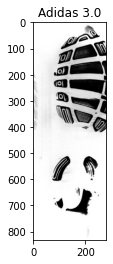

In [131]:
showResult(predicted_y[0],shoes_test.iloc[0], True)

[7.9044034e-09 5.5940332e-11 1.8461769e-15 9.9999976e-01 2.2673422e-07
 4.0878663e-12 9.3712210e-16]
[3 4 0 1 5 2 6]
[2.3107323e-01 7.5913107e-01 4.0065584e-07 4.3763909e-03 5.4068952e-03
 1.1864245e-05 8.7441826e-08]
[1 0 4 3 5 2 6]
[3.9835125e-01 8.9958578e-02 1.0146574e-03 4.7263354e-01 3.7680659e-02
 2.8845543e-04 7.2857314e-05]
[3 0 1 4 2 5 6]
[1.0920948e-02 6.8738973e-03 9.9263197e-08 4.1889714e-04 9.8178607e-01
 2.0448196e-09 1.2746925e-07]
[4 0 1 3 6 2 5]
[0.08999749 0.02887833 0.00639416 0.0106503  0.43868783 0.00062198
 0.42476985]
[4 6 0 1 3 2 5]


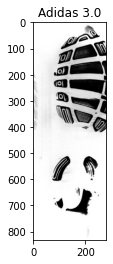

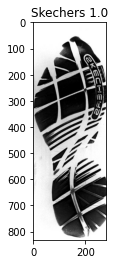

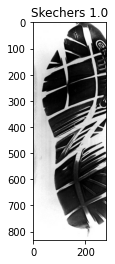

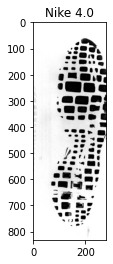

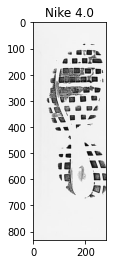

In [132]:
for i in range(5):
    showResult(predicted_y[i],shoes_test.iloc[i], True)

In [142]:
#Calular porcentaje que aparecen en las 3 primera posiciones 

def getXfirstOk(predicted, test, x):
    sort_index = np.argsort(-predicted)
    if test['factor_brand'] in sort_index[:x]:
        return True
    return False
        

In [143]:
getXfirstOk(predicted_y[0], shoes_test.iloc[0],3)

True

In [146]:
def checkAccuracyFirstPositions(predicted_y, shoes_test, x):
    total = len(predicted_y)
    ok = 0
    for i in range(total):
        if getXfirstOk(predicted_y[i],shoes_test.iloc[i],x):
            ok = ok+1

    print(ok)
    print(ok/total)


In [459]:
def executeModel(aumentation, gray, binary, crop, epoch):
   
    modelTest = createModelTest(not gray)
    
    modelTest.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    #Configurar el preprocesado que se hará en las imágenes desntro del Generator.
    trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,aumentation, "images/", gray, binary, crop)
    print(" ")
    print('Training model with aumentation:'+str(aumentation)+', gray:'+str(gray)+', binary:'+str(binary)+', crop:'+str(crop)+' and epochs = '+str(epoch))
    trainHistory = modelTest.fit(trainGenerator,validation_data=valGenerator, epochs=epoch)
    
    plot_history(trainHistory)
    
    predicted_y = modelTest.predict(testGenerator)
    print("Test evaluation:")
    print(modelTest.evaluate(testGenerator))
    print("% of correct brand in the first 3 positions:")
    print(checkAccuracyFirstPositions(predicted_y, shoes_test,3))
    
    

 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 56s 993ms/step - loss: 1.9069 - accuracy: 0.2647 - val_loss: 1.8830 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 57s 1s/step - loss: 1.8777 - accuracy: 0.2760 - val_loss: 1.8581 - val_accuracy: 0.3333
Epoch 3/10
53/53 [==============================] - 109s 2s/step - loss: 1.8647 - accuracy: 0.3006 - val_loss: 1.8385 - val_accuracy: 0.3333
Epoch 4/10
53/53 [==============================] - 89s 2s/step - loss: 1.8539 - accuracy: 0.2930 - val_loss: 1.8618 - val_accuracy: 0.3333
Epoch 5/10
53/53 [==============================] - 75s 1s/step - loss: 1.8570 - accuracy: 0.3025 - val_loss: 1.9045 - val_accuracy: 0.3333
Epoch 6/10
53/53 [==============================] - 73s 1s/step - loss: 1.8563 - accuracy: 0.3025 - val_loss: 1.8437 - val_accuracy: 0.3333
Epoch 7/10
53/53 [==============================] - 75s 1s/ste

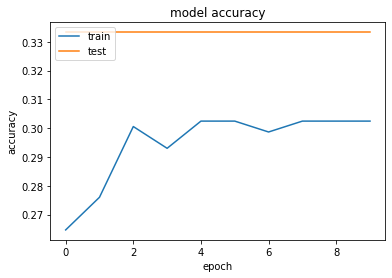

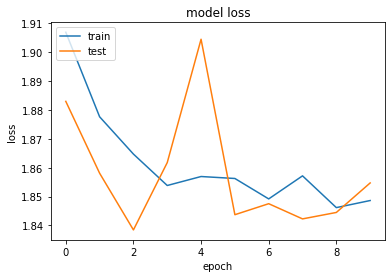

16/16 [==============================] - 5s 282ms/step
Test evaluation:
16/16 [==============================] - 5s 297ms/step - loss: 1.8416 - accuracy: 0.3312
[1.841644525527954, 0.3311688303947449]
% of correct brand in the first 3 positions:
97
0.6298701298701299
None


In [460]:
executeModel(False, False, False, False, 10)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 78s 1s/step - loss: 4.3415 - accuracy: 0.2401 - val_loss: 1.7591 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 75s 1s/step - loss: 1.8051 - accuracy: 0.2987 - val_loss: 1.7831 - val_accuracy: 0.2989
Epoch 3/10
53/53 [==============================] - 74s 1s/step - loss: 1.7308 - accuracy: 0.3119 - val_loss: 1.5948 - val_accuracy: 0.3563
Epoch 4/10
53/53 [==============================] - 71s 1s/step - loss: 1.6568 - accuracy: 0.3176 - val_loss: 1.5219 - val_accuracy: 0.4023
Epoch 5/10
53/53 [==============================] - 74s 1s/step - loss: 1.5729 - accuracy: 0.3837 - val_loss: 1.5147 - val_accuracy: 0.3908
Epoch 6/10
53/53 [==============================] - 74s 1s/step - loss: 1.5318 - accuracy: 0.3611 - val_loss: 1.3804 - val_accuracy: 0.4713
Epoch 7/10
53/53 [==============================] - 72s 1s/step - l

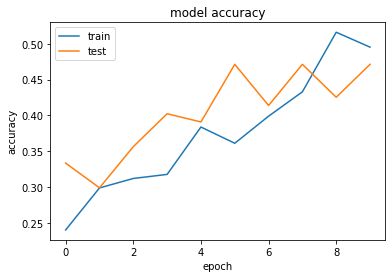

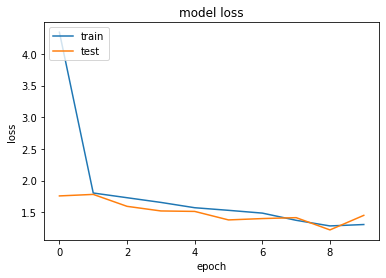

16/16 [==============================] - 9s 522ms/step
Test evaluation:
16/16 [==============================] - 9s 538ms/step - loss: 1.6539 - accuracy: 0.4545
[1.6538931131362915, 0.4545454680919647]
% of correct brand in the first 3 positions:
92
0.5974025974025974
None


In [461]:
executeModel(True, False, False, False, 10)

 
Training model with aumentation:False, gray:True, binary:False, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 65s 1s/step - loss: 1.8723 - accuracy: 0.2836 - val_loss: 1.8420 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 60s 1s/step - loss: 1.8711 - accuracy: 0.3043 - val_loss: 1.8952 - val_accuracy: 0.3333
Epoch 3/10
53/53 [==============================] - 60s 1s/step - loss: 1.8503 - accuracy: 0.3025 - val_loss: 1.8553 - val_accuracy: 0.3333
Epoch 4/10
53/53 [==============================] - 59s 1s/step - loss: 1.8393 - accuracy: 0.2987 - val_loss: 1.8536 - val_accuracy: 0.3333
Epoch 5/10
53/53 [==============================] - 59s 1s/step - loss: 1.8617 - accuracy: 0.2930 - val_loss: 1.8507 - val_accuracy: 0.3333
Epoch 6/10
53/53 [==============================] - 59s 1s/step - loss: 1.8532 - accuracy: 0.3006 - val_loss: 1.8586 - val_accuracy: 0.3333
Epoch 7/10
53/53 [==============================] - 58s 1s/step - l

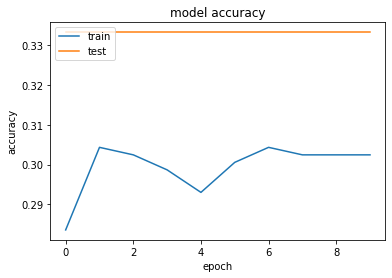

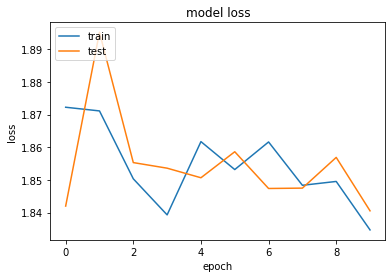

16/16 [==============================] - 4s 224ms/step
Test evaluation:
16/16 [==============================] - 4s 230ms/step - loss: 1.8248 - accuracy: 0.3312
[1.8247859477996826, 0.3311688303947449]
% of correct brand in the first 3 positions:
97
0.6298701298701299
None


In [462]:
executeModel(False, True, False, False, 10)

 
Training model with aumentation:False, gray:True, binary:True, crop:False and epochs = 10
Epoch 1/10
53/53 [==============================] - 79s 1s/step - loss: 2.3510 - accuracy: 0.2703 - val_loss: 1.8599 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 52s 976ms/step - loss: 1.7261 - accuracy: 0.3497 - val_loss: 1.4955 - val_accuracy: 0.4253
Epoch 3/10
53/53 [==============================] - 51s 961ms/step - loss: 1.4232 - accuracy: 0.4802 - val_loss: 1.2958 - val_accuracy: 0.4943
Epoch 4/10
53/53 [==============================] - 52s 972ms/step - loss: 1.0007 - accuracy: 0.6446 - val_loss: 0.9699 - val_accuracy: 0.6207
Epoch 5/10
53/53 [==============================] - 52s 986ms/step - loss: 0.7885 - accuracy: 0.7070 - val_loss: 1.2495 - val_accuracy: 0.6207
Epoch 6/10
53/53 [==============================] - 54s 1s/step - loss: 0.6689 - accuracy: 0.7505 - val_loss: 1.0293 - val_accuracy: 0.6552
Epoch 7/10
53/53 [==============================] - 53s 

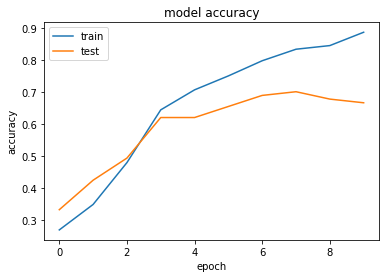

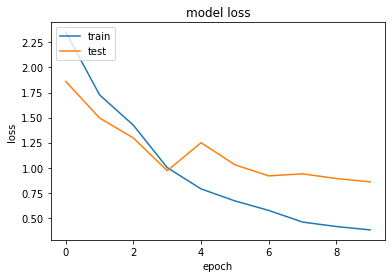

16/16 [==============================] - 3s 198ms/step
Test evaluation:
16/16 [==============================] - 3s 200ms/step - loss: 1.1299 - accuracy: 0.6364
[1.1299312114715576, 0.6363636255264282]
% of correct brand in the first 3 positions:
137
0.8896103896103896
None


In [463]:
executeModel(False, True, True, False, 10)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 56s 983ms/step - loss: 2.2715 - accuracy: 0.2760 - val_loss: 1.7214 - val_accuracy: 0.3563
Epoch 2/10
53/53 [==============================] - 53s 996ms/step - loss: 1.4275 - accuracy: 0.4329 - val_loss: 1.1458 - val_accuracy: 0.5517
Epoch 3/10
53/53 [==============================] - 53s 988ms/step - loss: 0.8800 - accuracy: 0.6862 - val_loss: 1.1601 - val_accuracy: 0.5977
Epoch 4/10
53/53 [==============================] - 54s 1s/step - loss: 0.7207 - accuracy: 0.7713 - val_loss: 1.1748 - val_accuracy: 0.6092
Epoch 5/10
53/53 [==============================] - 53s 994ms/step - loss: 0.4323 - accuracy: 0.8658 - val_loss: 1.3042 - val_accuracy: 0.7011
Epoch 6/10
53/53 [==============================] - 53s 1s/step - loss: 0.3196 - accuracy: 0.8960 - val_loss: 1.1201 - val_accuracy: 0.6782
Epoch 7/10
53/53 [==============================] - 54s 1

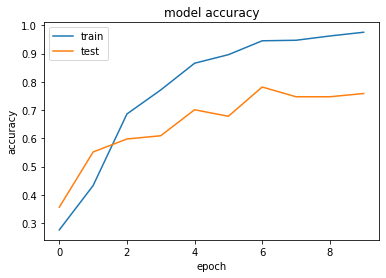

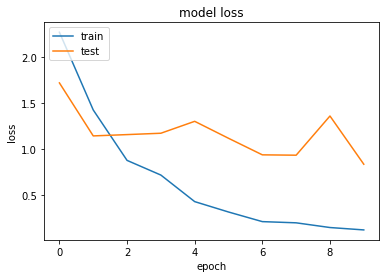

16/16 [==============================] - 3s 201ms/step
Test evaluation:
16/16 [==============================] - 3s 196ms/step - loss: 0.7390 - accuracy: 0.7403
[0.738982081413269, 0.7402597665786743]
% of correct brand in the first 3 positions:
149
0.9675324675324676
None


In [464]:
executeModel(False, True, True, True, 10)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 10
Epoch 1/10
53/53 [==============================] - 70s 1s/step - loss: 4.4094 - accuracy: 0.2325 - val_loss: 1.8973 - val_accuracy: 0.3333
Epoch 2/10
53/53 [==============================] - 66s 1s/step - loss: 1.9097 - accuracy: 0.3157 - val_loss: 1.9134 - val_accuracy: 0.3103
Epoch 3/10
53/53 [==============================] - 63s 1s/step - loss: 1.8362 - accuracy: 0.3025 - val_loss: 1.8134 - val_accuracy: 0.3333
Epoch 4/10
53/53 [==============================] - 62s 1s/step - loss: 1.8044 - accuracy: 0.3214 - val_loss: 1.8021 - val_accuracy: 0.3103
Epoch 5/10
53/53 [==============================] - 65s 1s/step - loss: 1.8558 - accuracy: 0.3025 - val_loss: 1.8269 - val_accuracy: 0.3333
Epoch 6/10
53/53 [==============================] - 65s 1s/step - loss: 1.7787 - accuracy: 0.3289 - val_loss: 1.7170 - val_accuracy: 0.3563
Epoch 7/10
53/53 [==============================] - 66s 1s/step - loss

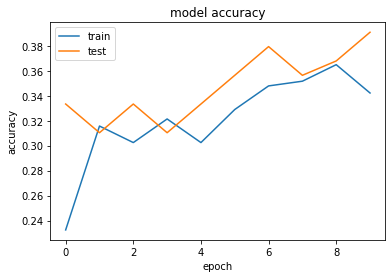

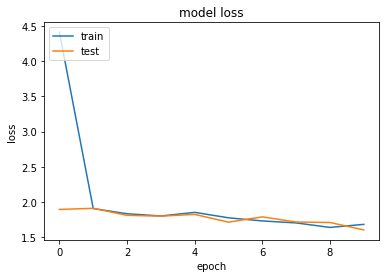

16/16 [==============================] - 6s 373ms/step
Test evaluation:
16/16 [==============================] - 7s 424ms/step - loss: 1.6327 - accuracy: 0.3831
[1.6326556205749512, 0.38311687111854553]
% of correct brand in the first 3 positions:
94
0.6103896103896104
None


In [470]:
executeModel(True, True, True, True, 10)

 
Training model with aumentation:False, gray:False, binary:False, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 59s 1s/step - loss: 1.9028 - accuracy: 0.2401 - val_loss: 1.8766 - val_accuracy: 0.3333
Epoch 2/25
53/53 [==============================] - 74s 1s/step - loss: 1.8666 - accuracy: 0.2911 - val_loss: 1.8399 - val_accuracy: 0.3333
Epoch 3/25
53/53 [==============================] - 78s 1s/step - loss: 1.8529 - accuracy: 0.3006 - val_loss: 1.8447 - val_accuracy: 0.3333
Epoch 4/25
53/53 [==============================] - 71s 1s/step - loss: 1.8764 - accuracy: 0.2930 - val_loss: 1.8470 - val_accuracy: 0.3333
Epoch 5/25
53/53 [==============================] - 68s 1s/step - loss: 1.8588 - accuracy: 0.3025 - val_loss: 1.8284 - val_accuracy: 0.3333
Epoch 6/25
53/53 [==============================] - 67s 1s/step - loss: 1.8584 - accuracy: 0.3025 - val_loss: 1.8405 - val_accuracy: 0.3333
Epoch 7/25
53/53 [==============================] - 64s 1s/step - 

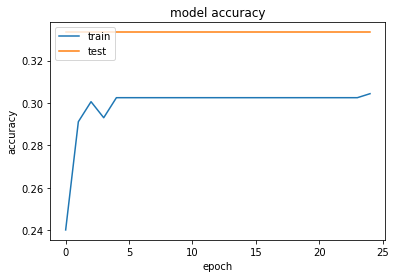

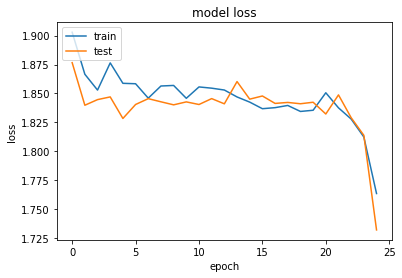

16/16 [==============================] - 5s 290ms/step
Test evaluation:
16/16 [==============================] - 6s 370ms/step - loss: 1.7299 - accuracy: 0.3312
[1.7299422025680542, 0.3311688303947449]
% of correct brand in the first 3 positions:
97
0.6298701298701299
None


In [465]:
executeModel(False, False, False, False, 25)

 
Training model with aumentation:True, gray:False, binary:False, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 81s 1s/step - loss: 3.3676 - accuracy: 0.2647 - val_loss: 1.8782 - val_accuracy: 0.3333
Epoch 2/25
53/53 [==============================] - 94s 2s/step - loss: 1.8057 - accuracy: 0.2798 - val_loss: 1.7696 - val_accuracy: 0.3333
Epoch 3/25
53/53 [==============================] - 84s 2s/step - loss: 1.6621 - accuracy: 0.3365 - val_loss: 1.6796 - val_accuracy: 0.3333
Epoch 4/25
53/53 [==============================] - 78s 1s/step - loss: 1.4856 - accuracy: 0.4197 - val_loss: 1.4189 - val_accuracy: 0.4253
Epoch 5/25
53/53 [==============================] - 72s 1s/step - loss: 1.4414 - accuracy: 0.4367 - val_loss: 1.2754 - val_accuracy: 0.4598
Epoch 6/25
53/53 [==============================] - 76s 1s/step - loss: 1.2771 - accuracy: 0.4915 - val_loss: 1.3979 - val_accuracy: 0.4713
Epoch 7/25
53/53 [==============================] - 80s 2s/step - l

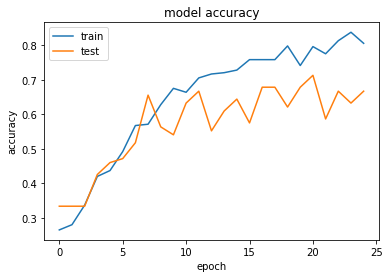

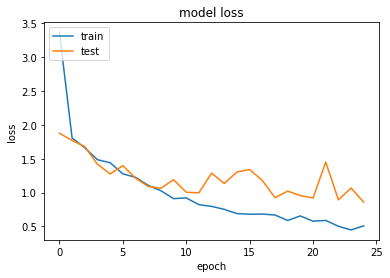

16/16 [==============================] - 9s 549ms/step
Test evaluation:
16/16 [==============================] - 9s 569ms/step - loss: 0.7312 - accuracy: 0.7273
[0.7312448024749756, 0.7272727489471436]
% of correct brand in the first 3 positions:
89
0.577922077922078
None


In [466]:
executeModel(True, False, False, False, 25)

 
Training model with aumentation:False, gray:True, binary:False, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 65s 1s/step - loss: 1.9029 - accuracy: 0.2439 - val_loss: 1.8329 - val_accuracy: 0.3333
Epoch 2/25
53/53 [==============================] - 57s 1s/step - loss: 1.8767 - accuracy: 0.2760 - val_loss: 1.8206 - val_accuracy: 0.3333
Epoch 3/25
53/53 [==============================] - 59s 1s/step - loss: 1.8537 - accuracy: 0.3119 - val_loss: 1.8360 - val_accuracy: 0.3333
Epoch 4/25
53/53 [==============================] - 60s 1s/step - loss: 1.8635 - accuracy: 0.3006 - val_loss: 1.8477 - val_accuracy: 0.3333
Epoch 5/25
53/53 [==============================] - 59s 1s/step - loss: 1.8612 - accuracy: 0.3006 - val_loss: 1.8372 - val_accuracy: 0.3333
Epoch 6/25
53/53 [==============================] - 61s 1s/step - loss: 1.8515 - accuracy: 0.3006 - val_loss: 1.8436 - val_accuracy: 0.3333
Epoch 7/25
53/53 [==============================] - 58s 1s/step - l

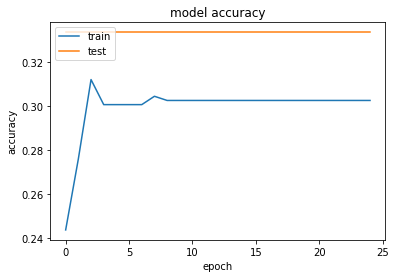

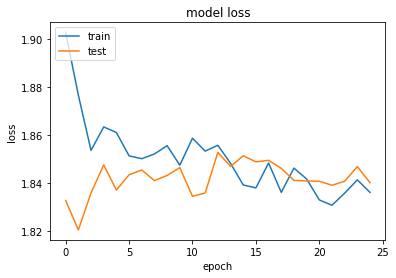

16/16 [==============================] - 3s 199ms/step
Test evaluation:
16/16 [==============================] - 5s 279ms/step - loss: 1.8261 - accuracy: 0.3312
[1.826066255569458, 0.3311688303947449]
% of correct brand in the first 3 positions:
97
0.6298701298701299
None


In [467]:
executeModel(False, True, False, False, 25)

 
Training model with aumentation:False, gray:True, binary:True, crop:False and epochs = 25
Epoch 1/25
53/53 [==============================] - 64s 1s/step - loss: 2.2998 - accuracy: 0.2609 - val_loss: 1.6451 - val_accuracy: 0.3333
Epoch 2/25
53/53 [==============================] - 57s 1s/step - loss: 1.5276 - accuracy: 0.4197 - val_loss: 1.3818 - val_accuracy: 0.4713
Epoch 3/25
53/53 [==============================] - 57s 1s/step - loss: 1.0998 - accuracy: 0.6125 - val_loss: 1.2970 - val_accuracy: 0.5517
Epoch 4/25
53/53 [==============================] - 56s 1s/step - loss: 0.8210 - accuracy: 0.7032 - val_loss: 1.3018 - val_accuracy: 0.5402
Epoch 5/25
53/53 [==============================] - 56s 1s/step - loss: 0.6247 - accuracy: 0.7921 - val_loss: 1.1787 - val_accuracy: 0.6322
Epoch 6/25
53/53 [==============================] - 56s 1s/step - loss: 0.3893 - accuracy: 0.8733 - val_loss: 1.4717 - val_accuracy: 0.5747
Epoch 7/25
53/53 [==============================] - 56s 1s/step - lo

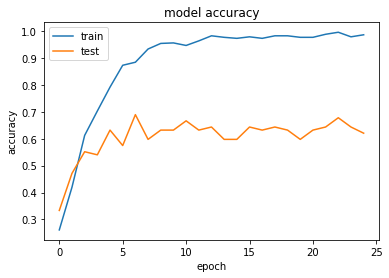

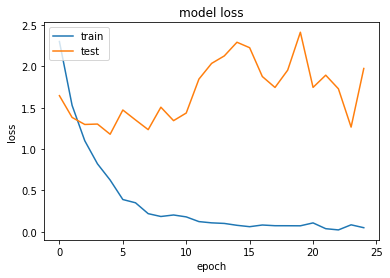

16/16 [==============================] - 3s 199ms/step
Test evaluation:
16/16 [==============================] - 3s 197ms/step - loss: 2.5348 - accuracy: 0.5844
[2.534780263900757, 0.5844155550003052]
% of correct brand in the first 3 positions:
132
0.8571428571428571
None


In [468]:
executeModel(False, True, True, False, 25)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 25
Epoch 1/25
53/53 [==============================] - 59s 1s/step - loss: 2.3622 - accuracy: 0.2684 - val_loss: 1.6440 - val_accuracy: 0.3563
Epoch 2/25
53/53 [==============================] - 56s 1s/step - loss: 1.3603 - accuracy: 0.4972 - val_loss: 1.2239 - val_accuracy: 0.5977
Epoch 3/25
53/53 [==============================] - 60s 1s/step - loss: 0.8507 - accuracy: 0.6824 - val_loss: 1.1792 - val_accuracy: 0.6322
Epoch 4/25
53/53 [==============================] - 60s 1s/step - loss: 0.5519 - accuracy: 0.8242 - val_loss: 1.1181 - val_accuracy: 0.6782
Epoch 5/25
53/53 [==============================] - 59s 1s/step - loss: 0.3886 - accuracy: 0.8752 - val_loss: 0.9903 - val_accuracy: 0.7241
Epoch 6/25
53/53 [==============================] - 59s 1s/step - loss: 0.2839 - accuracy: 0.9187 - val_loss: 0.8305 - val_accuracy: 0.6667
Epoch 7/25
53/53 [==============================] - 60s 1s/step - los

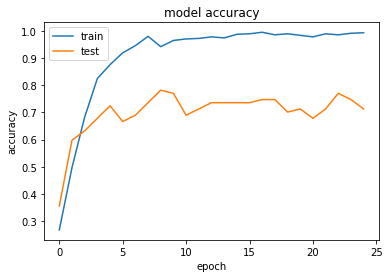

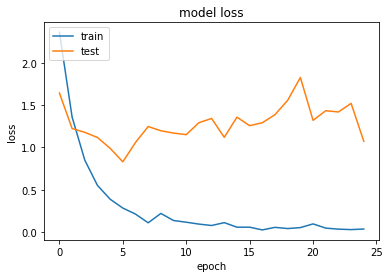

16/16 [==============================] - 4s 223ms/step
Test evaluation:
16/16 [==============================] - 4s 225ms/step - loss: 0.8889 - accuracy: 0.8247
[0.8888569474220276, 0.8246753215789795]
% of correct brand in the first 3 positions:
152
0.987012987012987
None


In [469]:
executeModel(False, True, True, True, 25)

In [ ]:
executeModel(True, True, True, True, 25)

### Stanford model from paper (BORRAR)

In [186]:
#Modelo del paper http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf:

model_standford = models.Sequential([
  #Rescaling(1./255, input_shape=(280,832,3)),
  Conv2D(32, 3, padding='same', activation='relu', input_shape=(280,832,1)),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dense(64, activation='relu'),
  Dense(num_classes)
  #Dense(num_classes,activation='softmax')
  # ,Flatten()
])

model_standford.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 280, 832, 32)      320       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 140, 416, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 140, 416, 32)      9248      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 70, 208, 32)      0         
 g2D)                                                            
                                                                 
 dense_28 (Dense)            (None, 70, 208, 64)       2112      
                                                                 
 dense_29 (Dense)            (None, 70, 208, 7)      

In [187]:
model_standford.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [188]:
trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,True, "images/")
testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/")
valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/")

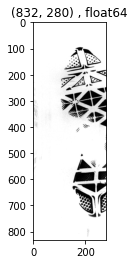

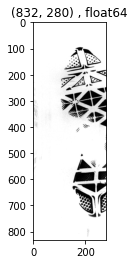

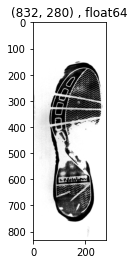

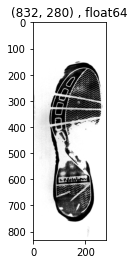

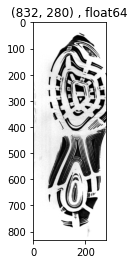

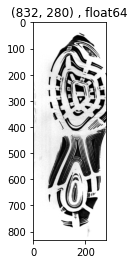

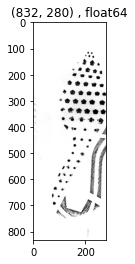

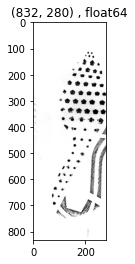

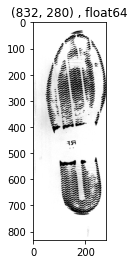

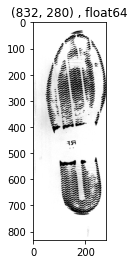

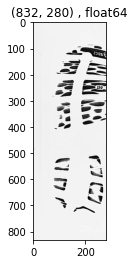

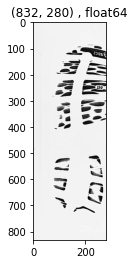

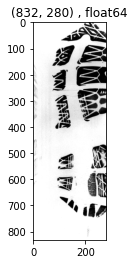

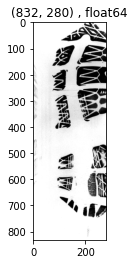

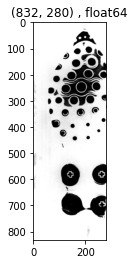

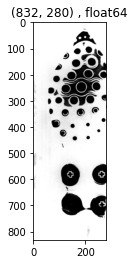

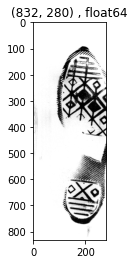

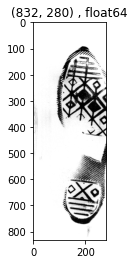

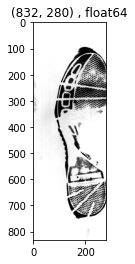

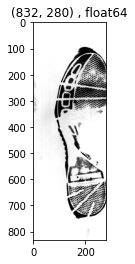

Epoch 1/10


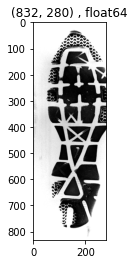

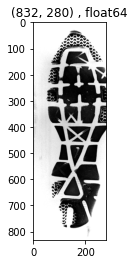

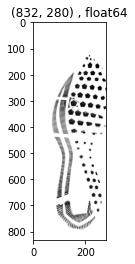

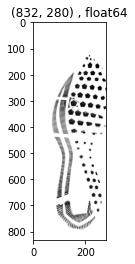

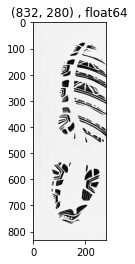

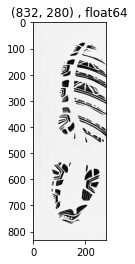

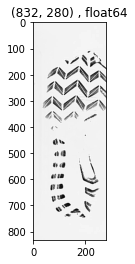

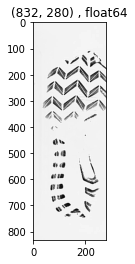

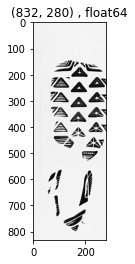

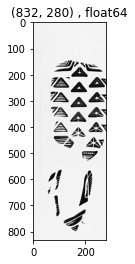

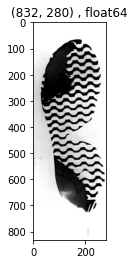

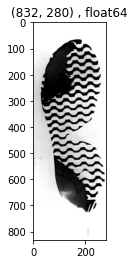

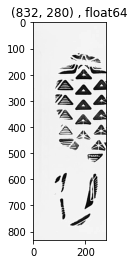

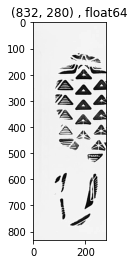

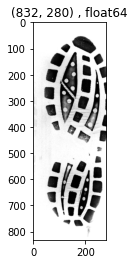

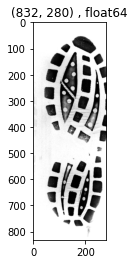

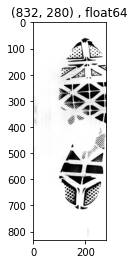

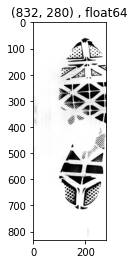

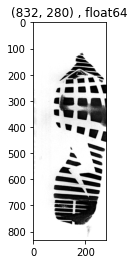

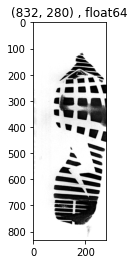

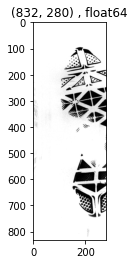

InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 193, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/traitlets/config/application.py", line 664, in launch_instance
      app.start()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 583, in start
      self.io_loop.start()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 149, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/ioloop.py", line 743, in _run_callback
      ret = callback()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 787, in inner
      self.run()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2857, in run_cell
      result = self._run_cell(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
      return runner(coro)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3062, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-189-5329f888788b>", line 1, in <module>
      historyStanford = model_standford.fit(trainGenerator,validation_data=valGenerator, epochs=10)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1028, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1122, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 691, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/metrics/metrics.py", line 3669, in sparse_categorical_accuracy
      matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 970, in sparse_categorical_matches
      matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal'
Incompatible shapes: [10,208,70] vs. [10]
	 [[{{node Equal}}]] [Op:__inference_train_function_33140]

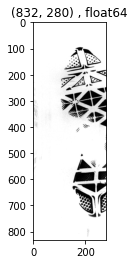

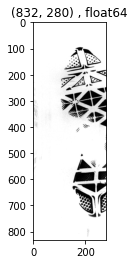

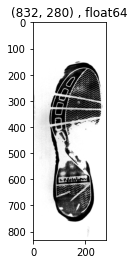

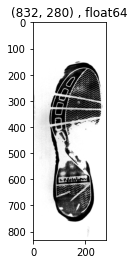

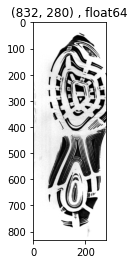

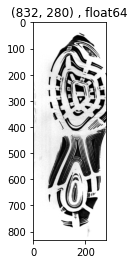

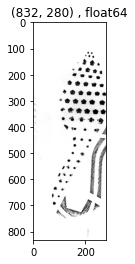

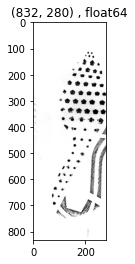

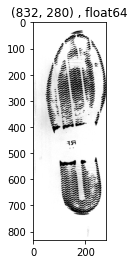

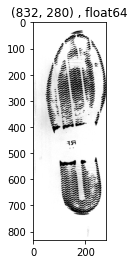

In [189]:
historyStanford = model_standford.fit(trainGenerator,validation_data=valGenerator, epochs=10)

In [ ]:
model_standford.evaluate(testGenerator)

In [ ]:
predicted_standford = model_standford.predict(testGenerator)

In [ ]:
checkAccuracy3First(predicted_standford, shoes_test)

In [ ]:
showResult(predicted_standford[0],shoes_test.iloc[0], True)

### Uso de autokeras
La librería autokeras se encarga de buscar la combinación de Layers del modelo que puede obtener mejor resultado.


In [148]:
#autokeras

!pip install autokeras

  Using cached MarkupSafe-2.1.2-cp38-cp38-macosx_10_9_x86_64.whl (13 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


In [149]:
import autokeras as ak

In [161]:
import tensorflow as tf #¿NO SE USA?
batch_size=10

train3_loader = torch.utils.data.DataLoader(DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,False, "images/"))

test3_loader = torch.utils.data.DataLoader(DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/"))

ex_train = enumerate(train3_loader)
train_batch_idx, (train_data, train_annotation) = next(ex_train)

ex_test = enumerate(test3_loader)
test_batch_idx, (test_data, test_annotation) = next(ex_test)


#test_data = torch.moveaxis (test_data, 1, -1)
#train_data = torch.moveaxis (train_data, 1, -1)

train_set = tf.data.Dataset.from_tensor_slices ((train_data, train_annotation))
test_set = tf.data.Dataset.from_tensor_slices ((test_data, test_annotation))


trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,False, "images/")
testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/")
valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/")

trainGenerator.__getitem__(0)[0].shape

(10, 280, 832)

In [162]:
#https://autokeras.com/image_classifier/
#https://medium.com/analytics-vidhya/how-to-use-autokeras-to-build-image-classification-models-using-one-line-of-code-c35b0c36e66e

images_train = np.empty([280,832], dtype=int)

X = np.array([io.imread("images/"+p) for p in shoes_train.X.values])

print(X.shape)


(529, 832, 280, 3)


In [164]:
clf = ak.ImageClassifier( num_classes=num_classes, max_trials=1,loss = 'binary_crossentropy',
     objective='val_accuracy')

# Feed the tensorflow Dataset to the classifier.
autohistory = clf.fit(X, shoes_train['y'],epochs=10, validation_split = 0.2)



INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json


INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
17/17 [==============================] - 161s 9s/step - loss: 50.6051 - accuracy: 0.2703
Epoch 2/10
17/17 [==============================] - 171s 10s/step - loss: 1.2036 - accuracy: 0.7221
Epoch 3/10
17/17 [==============================] - 168s 10s/step - loss: 0.1539 - accuracy: 0.9622
Epoch 4/10
17/17 [==============================] - 161s 9s/step - loss: 0.0064 - accuracy: 1.0000
Epoch 5/10
17/17 [==============================] - 162s 9s/step - loss: 0.0014 - accuracy: 1.0000
Epoch 6/10
17/17 [==============================] - 156s 9s/step - loss: 8.1961e-04 - accuracy: 1.0000
Epoch 7/10
17/17 [==============================] - 155s 9s/step - loss: 6.1800e-04 - accuracy: 1.0000
Epoch 8/10
17/17 [==============================] - 154s 9s/step - loss: 5.3839e-04 - accuracy: 1.0000
Epoch 9/10
17/17 [==============================] - 181s 11s/step - loss: 4.2345e-04 - accuracy: 1.0000
Epoch 10/10
17/17 [==============================] - 165s 10s/step - loss: 3.1704e-04 - a

INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 832, 280, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 832, 280, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 832, 280, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 830, 278, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 828, 276, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 414, 138, 64)     0     

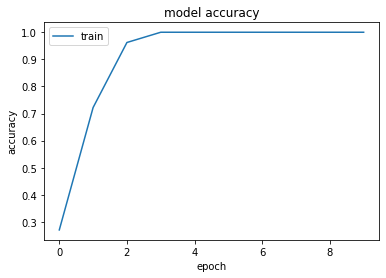

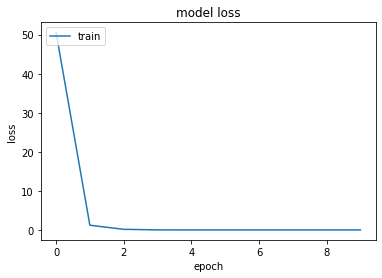

In [165]:
model = clf.export_model()

# Para ver la información de la función summary() que incluye las capas del mejor modelo
model.summary()

#with open('saved/auto_model.pkl', 'wb') as fp:
#        pickle.dump(model, fp)
#        print('Model saved successfully to file')

#print(autohistory.history)
plot_history_2(autohistory)

In [166]:
# Predict with the best model.
test = np.empty([280,832], dtype=int)

test = np.array([io.imread("images/"+p) for p in shoes_test.X.values])

predicted_auto_y = clf.predict(test)


5/5 [==============================] - 9s 2s/step


In [167]:

# Evaluate the best model with testing data.
print(clf.evaluate(test, shoes_test['y']))

5/5 [==============================] - 9s 2s/step - loss: 1.6832 - accuracy: 0.5584
[1.683178424835205, 0.5584415793418884]


['Asics']


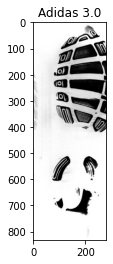

In [168]:
showResult(predicted_auto_y[0],shoes_test.iloc[0], False)

In [170]:
checkAccuracyFirstPositions(predicted_auto_y, shoes_test,3)

UFuncTypeError: ufunc 'negative' did not contain a loop with signature matching types <class 'numpy.dtype[str_]'> -> None

In [171]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(confusion_matrix(shoes_test['y'],predicted_auto_y))


[[13  1  0  9  0  0  0]
 [ 0 12  0 11  0  0  0]
 [ 0  0  5  5  0  0  0]
 [ 4  1  0 45  0  0  1]
 [ 0  0  0 11  2  0  0]
 [ 5  1  0 11  0  2  0]
 [ 2  0  0  6  0  0  7]]


Se obtiene una eficacia del 44%, bastante baja respecto a la de entrenamiento.

¿Esto implica sobreentrenamiento?

### Mejoras al modelo propuesto

### Uso de modelo pre-entrenado ImageNet

VGG16 tal cual

In [420]:
#https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29

from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, BatchNormalization
import ssl
#se usa para evitar el error SSL que lanza VGG16
ssl._create_default_https_context = ssl._create_unverified_context

#vgg16 por defecto usa ImageNet:
modelPre = models.Sequential()
modelPre.add(VGG16(include_top=False, input_shape=(832, 280, 1), 
                   weights="imagenet", classes = num_classes, classifier_activation="softmax"))
modelPre.add(Flatten())
modelPre.add(Dense(512, activation='relu'))
modelPre.add(BatchNormalization())
modelPre.add(Dropout(0.5))
modelPre.add(Dense(num_classes))



modelPre.summary()

#inp = Input(shape= (320,872, 3))
#out = VGG16(weights='imagenet')(inp)
#modelPre = Model(inputs=inp, outputs=out)

ValueError: The input must have 3 channels; Received `input_shape=(832, 280, 1)`

VGG16 con capas extras

In [426]:
#pruebas
vgg_model = VGG16(include_top=False, input_shape=(832, 280, 3))
for layer in vgg_model.layers[-4:]:
    layer.trainable = True
    
modelPre = models.Sequential()
modelPre.add(vgg_model)
modelPre.add(Flatten())
modelPre.add(Dense(512, activation='relu'))
modelPre.add(BatchNormalization())
modelPre.add(Dropout(0.5))
modelPre.add(Dense(num_classes))
modelPre.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 26, 8, 512)        14714688  
                                                                 
 flatten_54 (Flatten)        (None, 106496)            0         
                                                                 
 dense_63 (Dense)            (None, 512)               54526464  
                                                                 
 batch_normalization_264 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_64 (Dense)            (None, 7)                 3591      
                                                     

In [427]:
import tensorflow as tf
modelPre.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [428]:
trainGeneratorPre=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,False, "images/", False)
testGeneratorPre=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/", False)
valGeneratorPre=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/",False)
trainGeneratorPre.__getitem__(0)[0].shape



(10, 280, 832, 3)

In [429]:
preHistory = modelPre.fit(trainGeneratorPre,validation_data=valGeneratorPre, epochs=30)

Epoch 1/30
53/53 [==============================] - 1584s 30s/step - loss: 6.5179 - accuracy: 0.2268 - val_loss: 8.6945 - val_accuracy: 0.3333
Epoch 2/30
53/53 [==============================] - 1603s 30s/step - loss: 6.0029 - accuracy: 0.2136 - val_loss: 1.9459 - val_accuracy: 0.1149
Epoch 3/30
53/53 [==============================] - 1638s 31s/step - loss: 3.9804 - accuracy: 0.2023 - val_loss: 3.6444 - val_accuracy: 0.3333
Epoch 4/30
53/53 [==============================] - 1609s 30s/step - loss: 4.1506 - accuracy: 0.2552 - val_loss: 3.6444 - val_accuracy: 0.0805
Epoch 5/30
53/53 [==============================] - 1554s 29s/step - loss: 3.7050 - accuracy: 0.2854 - val_loss: 7.2964 - val_accuracy: 0.0920
Epoch 6/30
53/53 [==============================] - 1510s 28s/step - loss: 3.2062 - accuracy: 0.3062 - val_loss: 9.9085 - val_accuracy: 0.0805
Epoch 7/30
53/53 [==============================] - 1523s 29s/step - loss: 3.5710 - accuracy: 0.2647 - val_loss: 6.9443 - val_accuracy: 0.3333

KeyboardInterrupt: 

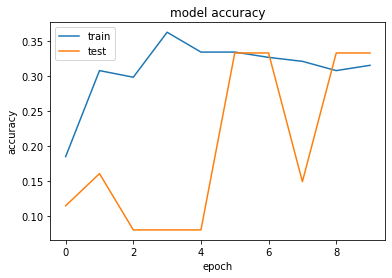

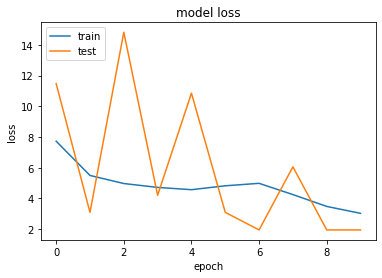

In [424]:
plot_history(preHistory)

Resultados muy bajos para ser con ImageNet.

In [425]:
print(modelPre.evaluate(testGeneratorPre))

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 193, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/traitlets/config/application.py", line 664, in launch_instance
      app.start()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 583, in start
      self.io_loop.start()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 149, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/ioloop.py", line 743, in _run_callback
      ret = callback()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 787, in inner
      self.run()
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2857, in run_cell
      result = self._run_cell(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
      return runner(coro)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3062, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-425-034e54b5d1ce>", line 1, in <module>
      print(modelPre.evaluate(testGeneratorPre))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1758, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/losses.py", line 2098, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/backend.py", line 5633, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [2329600,3] and labels shape [10]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_test_function_552730]

In [ ]:
pre_predicted_y = modelPre.predict(test)

In [ ]:
#Mostrar ejemplos
showResult(pre_predicted_y[0],shoes_test.iloc[0], False)

In [393]:
checkAccuracyFirstPositions(pre_predicted_y, shoes_test,3)

65
0.42207792207792205


RestNet50

In [412]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50


modelPre2 = models.Sequential()
modelPre2.add(ResNet50(include_top=False, input_shape=(832, 280, 3), 
                   weights="imagenet", classes = num_classes, classifier_activation="softmax"))
modelPre2.add(Flatten())
modelPre2.add(Dense(512, activation='relu'))
modelPre2.add(BatchNormalization())
modelPre2.add(Dropout(0.5))
modelPre2.add(Dense(num_classes))



modelPre.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 26, 8, 512)        14714688  
                                                                 
 flatten_51 (Flatten)        (None, 106496)            0         
                                                                 
 dense_57 (Dense)            (None, 512)               54526464  
                                                                 
 batch_normalization_261 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_58 (Dense)            (None, 7)                 3591      
                                                     

In [413]:

modelPre2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [414]:
trainGeneratorPre2=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,False, "images/", False)
testGeneratorPre2=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,False, "images/", False)
valGeneratorPre2=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,False, "images/",False)


In [415]:
preHistory2 = modelPre2.fit(trainGeneratorPre2,validation_data=valGeneratorPre2, epochs=10)

Epoch 1/10
53/53 [==============================] - 1907s 35s/step - loss: 4.4680 - accuracy: 0.1361 - val_loss: 4.3855 - val_accuracy: 0.1149
Epoch 2/10
53/53 [==============================] - 932s 17s/step - loss: 2.6667 - accuracy: 0.1626 - val_loss: 1.9459 - val_accuracy: 0.1609
Epoch 3/10
53/53 [==============================] - 961s 18s/step - loss: 2.8399 - accuracy: 0.1834 - val_loss: 1.9459 - val_accuracy: 0.1149
Epoch 4/10
53/53 [==============================] - 886s 17s/step - loss: 2.8528 - accuracy: 0.1758 - val_loss: 1.9459 - val_accuracy: 0.1149
Epoch 5/10
53/53 [==============================] - 916s 17s/step - loss: 3.5595 - accuracy: 0.1607 - val_loss: 1.9459 - val_accuracy: 0.1494
Epoch 6/10
53/53 [==============================] - 739s 14s/step - loss: 3.7119 - accuracy: 0.1947 - val_loss: 1.9459 - val_accuracy: 0.1494
Epoch 7/10
53/53 [==============================] - 746s 14s/step - loss: 3.0924 - accuracy: 0.1550 - val_loss: 1.9459 - val_accuracy: 0.1494
Epoch

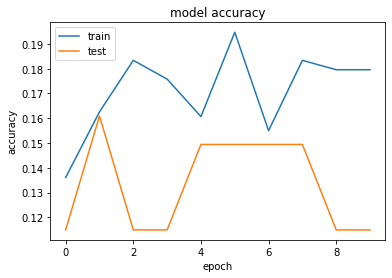

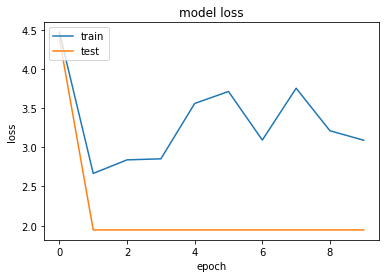

In [416]:
plot_history(preHistory2)

In [417]:
print(modelPre2.evaluate(testGeneratorPre2))

16/16 [==============================] - 41s 3s/step - loss: 1.9459 - accuracy: 0.1494
[1.9459102153778076, 0.14935064315795898]


In [418]:
pre_predicted_y2 = modelPre2.predict(test)

5/5 [==============================] - 41s 7s/step


In [419]:
checkAccuracyFirstPositions(pre_predicted_y2, shoes_test,3)

85
0.551948051948052


## One shot 

https://serokell.io/blog/nn-and-one-shot-learning

https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

https://connorshorten300.medium.com/one-shot-learning-70bd78da4120


## Análisis de resultados

(TODO)

# Objetivo 2: Búsqueda de similitud (FD300) First try

método No supervisado. 
La idea es crear dos CNN: una codifica las imagenes y la otra las decodifica.

https://github.com/luchonaveiro/image-search-engine/blob/master/02_Train_Autoencoder.ipynb

In [346]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
import tensorflow as tf

# Load images
img_height = 586
img_width = 156
channels = 1 #3 
batch_size = 16

def my_preprocessing_function(img):
    
    #Combines all the transformations
    #img = cv.imread('fid300/'+filename)
    #img = rgb2gray(img)
    test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
    #img = crop_image(img)
    #img = cv2.resize(img, (img_height, img_width), interpolation = cv2.INTER_AREA)
    img = np.expand_dims(img,-1)
   # img = gray2rgb(img)
    return img

 

train_datagen = ImageDataGenerator(preprocessing_function =my_preprocessing_function, rescale=1./255,
                                   validation_split=0.2)

#añadir funcion preprocessing_function para pasar a gris, binary y crop
training_set = train_datagen.flow_from_directory(
    'fid300/',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     classes=['references'],
     class_mode = 'input',
     subset = 'training',
     color_mode='grayscale',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    'fid300/',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     classes=['references'],
     subset = 'validation',
     class_mode = 'input',
     color_mode='grayscale',
     shuffle=False)

#Única clase porque no tengo classes / labels por imagen.

Found 940 images belonging to 1 classes.
Found 235 images belonging to 1 classes.


In [347]:
# Define the autoencoder
input_model = Input(shape=(img_height, img_width, channels))

print(input_model.shape)
# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(1, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

print(output.shape)

(None, 586, 156, 1)
(None, 586, 156, 1)


In [349]:
# Create model object
autoencoder = Model(input_model, output, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 586, 156, 1)]     0         
                                                                 
 conv2d_133 (Conv2D)         (None, 586, 156, 64)      640       
                                                                 
 leaky_re_lu_251 (LeakyReLU)  (None, 586, 156, 64)     0         
                                                                 
 batch_normalization_255 (Ba  (None, 586, 156, 64)     256       
 tchNormalization)                                               
                                                                 
 flatten_48 (Flatten)        (None, 5850624)           0         
                                                                 
 latent_space (Dense)        (None, 16)                93610000  
                                                       

In [350]:


# Compile the model
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3), metrics=['accuracy'])
#autoencoder.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])
# Fit the model
history = autoencoder.fit(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=10,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_autoencoder_2.h5', 
                                      monitor='val_loss', 
                                      verbose=0, 
                                      save_best_only=True, 
                                      save_weights_only=False)])



Epoch 1/10
58/58 [==============================] - 766s 13s/step - loss: 0.0913 - accuracy: 0.9121 - val_loss: 0.2836 - val_accuracy: 0.6598
Epoch 2/10
58/58 [==============================] - 849s 15s/step - loss: 0.0685 - accuracy: 0.9317 - val_loss: 0.0813 - val_accuracy: 0.9144
Epoch 3/10
58/58 [==============================] - 860s 14s/step - loss: 0.0204 - accuracy: 0.9808 - val_loss: 0.0089 - val_accuracy: 0.9911
Epoch 4/10
58/58 [==============================] - 1179s 20s/step - loss: 0.0125 - accuracy: 0.9870 - val_loss: 0.0089 - val_accuracy: 0.9911
Epoch 5/10
58/58 [==============================] - 812s 14s/step - loss: 0.0125 - accuracy: 0.9869 - val_loss: 0.0091 - val_accuracy: 0.9911
Epoch 6/10
58/58 [==============================] - 663s 11s/step - loss: 0.0123 - accuracy: 0.9870 - val_loss: 0.0088 - val_accuracy: 0.9911
Epoch 7/10
58/58 [==============================] - 840s 14s/step - loss: 0.0123 - accuracy: 0.9870 - val_loss: 0.0088 - val_accuracy: 0.9911
Epoch

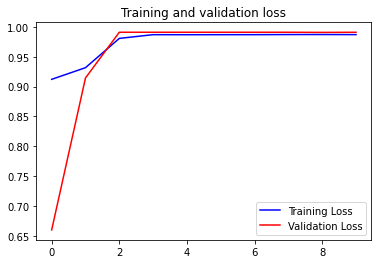

In [351]:
# Plot Accuracy and Loss
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
 
epochs = range(len(loss))
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [354]:
# Predict image function
def predict_image(image_dir, autoencoder):
  raw_image = load_img(image_dir, target_size=(img_height, img_width), color_mode = "grayscale")
  image = img_to_array(raw_image)
  image = np.expand_dims(image, axis=0)
  image = image / 255.0
  pred = autoencoder.predict(image)
  pred = pred * 255.0
  pred = np.reshape(pred, (img_height, img_width, 1))
  pred = array_to_img(pred)

  return raw_image, pred



1/1 [==============================] - 3s 3s/step


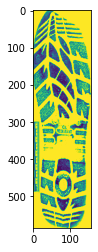

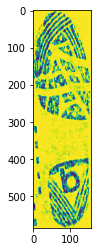

1/1 [==============================] - 0s 362ms/step


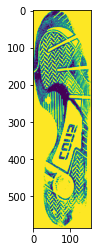

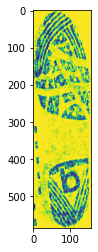

1/1 [==============================] - 0s 488ms/step


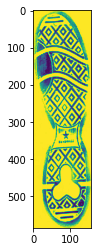

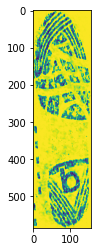

In [355]:
# Predict 3 images from training set
train_imgs = training_set.filepaths[0:3]

for i in train_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

In [357]:
autoencoder.save('models/image_autoencoder_2.h5')

In [377]:
import os
#Latent space:

#autoencoder = load_model('models/image_autoencoder.h5', compile=False)
latent_space_model = Model(autoencoder.input, autoencoder.get_layer('latent_space').output)

#
# Load all images and predict them with the latent space model
X = []
indices = []

for i in tqdm(range(len(os.listdir('./fid300/references')))):
  try:
    img_name = os.listdir('./fid300/references')[i]
    img = load_img('./fid300/references/{}'.format(img_name), 
                   target_size = (img_height, img_width))
    
    img = img_to_array(img) / 255.0
    img = cv2.resize(img, (img_height, img_width), interpolation = cv2.INTER_AREA)
    img = np.expand_dims(img, axis=0)
    pred = latent_space_model.predict(img)
    pred = np.resize(pred, (16))
    X.append(pred)
    indices.append(img_name)

  except Exception as e:
    print(img_name)
    print(e)

    # Export the embeddings
embeddings = {'indices': indices, 'features': np.array(X)}
pickle.dump(embeddings, 
            open('./fid300/image_embeddings.pickle', 'wb'))
#
def eucledian_distance(x,y):
  eucl_dist = np.linalg.norm(x - y)
  return eucl_dist



<ipython-input-377-ebb28c06f375>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(os.listdir('./fid300/references')))):


00481.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01012.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00126.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00907.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00522.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00523.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00721.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00133.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00696.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00443.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00327.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00657.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00904.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00290.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01171.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00520.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00044.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00642.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01004.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00483.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01028.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00685.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00083.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00281.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01148.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00519.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00069.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00135.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00323.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00486.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00321.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00123.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00080.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00282.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00526.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00042.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00650.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00877.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01016.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00347.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00192.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00794.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00025.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00541.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00226.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00024.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00178.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00187.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00346.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00350.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00813.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00967.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00768.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01106.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00225.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00741.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00153.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01067.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00386.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01063.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00194.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00976.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00989.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00553.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01102.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00778.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00156.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00354.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00381.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01048.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00626.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00791.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00587.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00544.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01101.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00009.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00627.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00431.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00394.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00366.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00831.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00789.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00574.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01131.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00993.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00978.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00818.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01079.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00365.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00198.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00952.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00588.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00238.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00748.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00947.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00199.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01085.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00412.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00176.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00764.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01136.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00229.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00995.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00611.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00375.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00388.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01069.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00954.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00015.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00571.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01134.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00955.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00821.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00438.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00311.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00113.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00715.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00265.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00264.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00099.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00660.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00310.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00306.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00676.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00925.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00266.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01151.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00071.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00887.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00688.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00313.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00303.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00883.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00049.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01155.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00510.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00074.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00666.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00841.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01020.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00300.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00102.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00076.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00274.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01157.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00088.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

00881.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

01037.png
in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from 

In [361]:
# Load embeddings
embeddings = pickle.load(open('./fid300/image_embeddings.pickle', 'rb'))

# Load images metadata
metadata = pd.read_csv('data/FID300/label_table.csv')

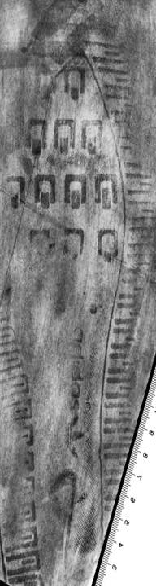

In [362]:
# Get image name
img_name = os.listdir('./fid300/tracks_cropped')[3]
img = load_img('./fid300/tracks_cropped/{}'.format(img_name), 
                   target_size = (img_height, img_width), color_mode='grayscale')
img

In [378]:
# Calculate eucledian distance
img_similarity = []
#cat_similarity = []

# Get actual image embedding
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
plt.imshow(img)

#img = my_preprocessing_function(img)
#img = cv2.resize(img, (img_height, img_width), interpolation = cv2.INTER_AREA)
#img = img_to_array(img) / 255.0
#img = np.expand_dims(img, axis=0)

pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))
ref_image = metadata.query("X == '{}'".format(int(img_name.replace('.jpg',''))))['y'].values[0]
#print('Image Category: {}'.format(img_cat))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate categoy similarity
  #cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
  #cat_sim = category_similarity(img_cat, cat)
  #cat_similarity.append(cat_sim)

imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity})


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
#imgs_result = imgs_result.iloc[0:20,:].sort_values(by='category_similarity', ascending=False).reset_index(drop=True)

# Show 10 first similar images
for i in range(3):
  image = load_img('./fid300/references/{}'.format(imgs_result['img'].values[i]))
  #category = metadata.query("id == '{}'".format(imgs_result['img'].values[i].replace('.jpg','')))['category'].values[0]
  
  # Show image
  plt.imshow(image)
  plt.show()
  print('Image Name: {}'.format("NAME"))
  print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))
  #print('Category Distance: {}'.format(imgs_result['category_similarity'].values[i]))

ValueError: Unsupported image shape: (1, 156, 586, 3)

# Analisis de resultados
